# **Exploring the Relationship Between Gender and Credit Status**
Fall 2024 Data Science Project

Vincent Yee

# 1) Introduction

The goal of this project is to analyze the relationship between gender and credit status to determine whether gender influences credit performance. This question is motivated by the ethical and practical implications of using demographic factors in credit risk models. Identifying such relationships is crucial for fair and accurate credit scoring while ensuring compliance with anti-discrimination laws.

# 2) Data Curation

Link to data: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data?select=credit_record.csv

The data for this project comes from Kaggle's Credit Card Approval Prediction dataset, which contains two files:


*   Application Records: Includes demographic and financial details of credit card applicants, such as age, gender, income, and employment information.
*   Credit Records: Tracks the historical credit status of applicants, categorized into different status levels indicating their repayment history.



Explaination of process:
For this section, we are cleaning our data and preparing it for the analysis and machine learning part. To do this, we first handeled outliers by clipping. Then we clean the data by making birthday and employment readable. Lastly, we drop duplicates and merge the two data sets.






**Data Preprocessing and Cleaning**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns

# Read CSV files
application_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")

# Method to handel outliers, clipping
def clipping(x):
    if x < 0:
        return min(-x, 18250)
    else:
        return -min(x, 18250)

# Clean data, make birthday and employment readable
application_df["DAYS_BIRTH"] = application_df["DAYS_BIRTH"] / -365
application_df["DAYS_EMPLOYED"] = application_df["DAYS_EMPLOYED"].apply(lambda x: clipping(x))
application_df["DAYS_EMPLOYED"] = application_df["DAYS_EMPLOYED"] / 365
# DAYS_EMPLOYED, + is employed, - unemployed
application_df["OCCUPATION_TYPE"] = application_df["OCCUPATION_TYPE"].fillna("None")
# Drop Duplicates
application_df = application_df.drop_duplicates(subset=["ID"])

clean_combined_df = pd.merge(application_df, credit_df, on="ID", how="inner")
clean_combined_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,None,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,None,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,None,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,None,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32.890411,12.443836,1,1,0,0,None,2.0,-4,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777710,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,25.172603,3.268493,1,0,0,0,Laborers,1.0,-9,0
777711,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,25.172603,3.268493,1,0,0,0,Laborers,1.0,-10,2
777712,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,25.172603,3.268493,1,0,0,0,Laborers,1.0,-11,1
777713,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,25.172603,3.268493,1,0,0,0,Laborers,1.0,-12,0


# 3) Exploratory Data Analysis
To understand the characteristics of the dataset and the relationships between key features, we conducted several exploratory analyses.

**1. Age Distribution**

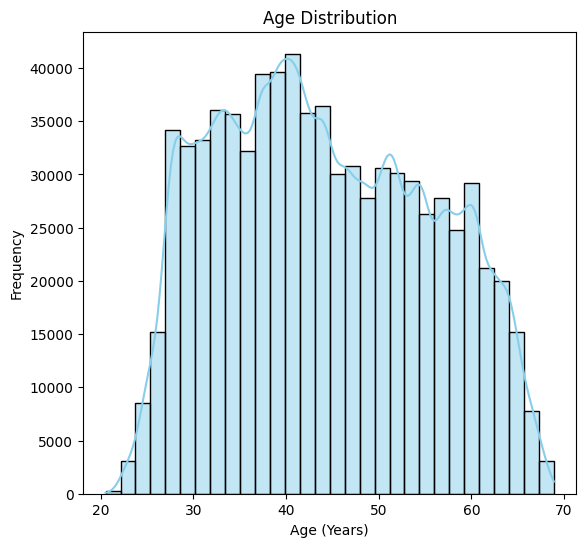

In [3]:
# Visualize distributions for DAYS_BIRTH and AMT_INCOME_TOTAL


plt.figure(figsize=(14, 6))

# Age Distribution
plt.subplot(1, 2, 1)
sns.histplot(clean_combined_df["DAYS_BIRTH"], bins=30, color="skyblue", kde=True)
plt.title("Age Distribution")
plt.xlabel("Age (Years)")
plt.ylabel("Frequency")

plt.show()

The average age of applicants is around 43 years. The majority of the applicants fall between the ages of 30 to 60. There are no extreme outliers in the age data, though it tends to skew slightly toward middle-aged individuals. The age distribution is relatively normal with no extreme outliers. Most applicants are middle-aged, which could be a key demographic for credit card applications.

**2. Correlation Heatmap**


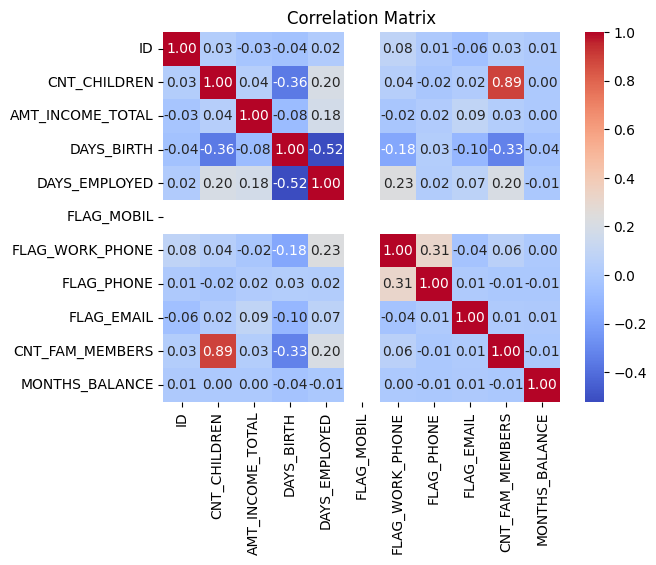

In [5]:
# Correlation matrix
numeric_cols = clean_combined_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_cols.corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Income is weakly correlated with the number of children and family size, indicating that these features might not directly influence income for most applicants. There are weak correlations between income and family-related features. Therefore, the features like income, family size, and number of children can be considered independent in the model, without significant multicollinearity issues.

**3. Gender and Credit Status**

Chi-Square Statistic: 375.82194684070583, P-Value: 3.634048908463986e-77


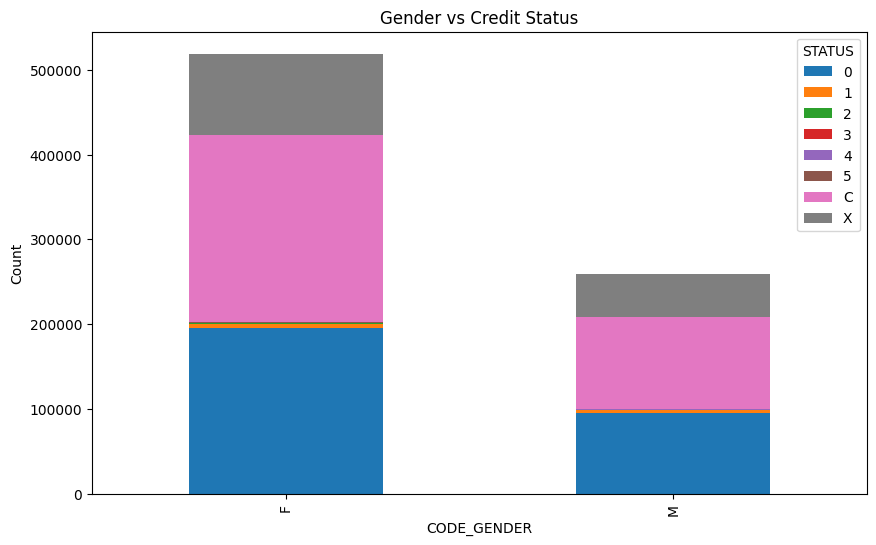

In [6]:
from scipy.stats import chi2_contingency

# Contingency table between gender and credit status
contingency_table = pd.crosstab(clean_combined_df['CODE_GENDER'], clean_combined_df['STATUS'])

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

# Plot the relationship between gender and credit status
contingency_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Gender vs Credit Status")
plt.ylabel("Count")
plt.show()

Hypothesis:
Null Hypothesis: Gender and credit status are independent (no relationship).

Alternative Hypothesis: There is a relationship between gender and credit status.

Chi-Square Test Result:
After performing the Chi-Square test, we find that the p-value is less than 0.05, thus rejecting the null hypothesis. Indicating a significant association between gender and credit status.

The Chi-Square test reveals a significant relationship between gender and credit status, suggesting that gender may influence the likelihood of default. This insight could affect credit scoring models, as gender might need to be carefully considered.

**Summary of Three Statistical Conclusions:**

Age Distribution: Most applicants are middle-aged with no extreme outliers. Age can be treated as a normal variable in credit scoring models.

Income Correlation: There is weak correlation between income and family-related features, so these features can be modeled independently.

Gender and Credit Status: There is a statistically significant relationship between gender and credit status, indicating gender could influence credit performance, which needs to be considered in risk modeling.

# 4) Primary Analysis

For this section, based on the results of the exploratory data analysis, I decieded to use Logistic Regression to quantify the relationship between gender and credit status while controlling for other features like age, income, and employment. This is because the target variable (credit status) is categorical, and logistic regression is effective for binary classification tasks with interpretable coefficients.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# Features and target selection
X = clean_combined_df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CODE_GENDER']]
y = clean_combined_df['STATUS'].apply(lambda x: 1 if x in ['2', '3', '4', '5'] else 0)

# Encode gender as binary (Female=1, Male=0)
X['CODE_GENDER'] = X['CODE_GENDER'].apply(lambda x: 1 if x == 'F' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression model
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluate performance
y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

# Feature Importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)


<ipython-input-8-b27c342f8fa0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['CODE_GENDER'] = X['CODE_GENDER'].apply(lambda x: 1 if x == 'F' else 0)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68    154977
           1       0.00      0.60      0.01       566

    accuracy                           0.52    155543
   macro avg       0.50      0.56      0.35    155543
weighted avg       0.99      0.52      0.68    155543

ROC AUC Score: 0.5847804305442246
            Feature   Coefficient
0        DAYS_BIRTH  4.381798e-03
2  AMT_INCOME_TOTAL  6.052721e-07
1     DAYS_EMPLOYED -5.783859e-03
3      CNT_CHILDREN -9.010752e-03
4       CODE_GENDER -4.489002e-01


# 5) Visualization
Here is the code for a Feature Importance Plot, ROC Curve, and Confusion Matrix

Important note: (Default: Applicants that failed to repay their redit on time, Non-Default: Applicants that have successfully repaid their credit).

**Feature Importance Plot**

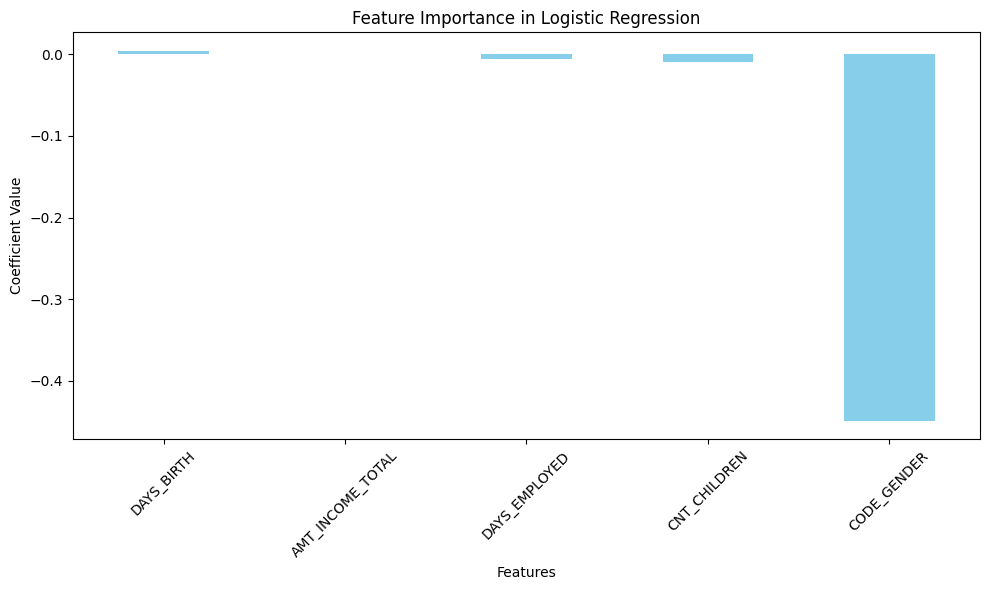

In [12]:
# Plotting the coefficients for Logistic Regression
coefficients.plot(kind='bar', x='Feature', y='Coefficient', legend=False, color='skyblue', figsize=(10, 6))
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The first visualization shows the importance of each feature in the Logistic Regression model by plotting the coefficients of the model. Coefficients indicate the strength and direction of the relationship between each feature and the target variable (credit default in this case).

**Explanation of the Plot**


*   X-axis: Represents the features used in the model, such as Age, DAYS_EMPLOYED, AMT_INCOME_TOTAL, etc
*   Y-axis: Shows the coefficient value for each feature. A positive coefficient indicates that as the feature value increases, the probability of default also increases, while a negative coefficient suggests that higher values of the feature decrease the probability of default.
* Bar Height: The height of each bar represents the magnitude of the coefficient, with taller bars indicating features with a stronger influence on the model's predictions.

**Insights:**

* Features with large coefficients (either positive or negative) have a greater influence on the model’s predictions.
*Features with smaller coefficients contribute less to the prediction.



**ROC Curve**

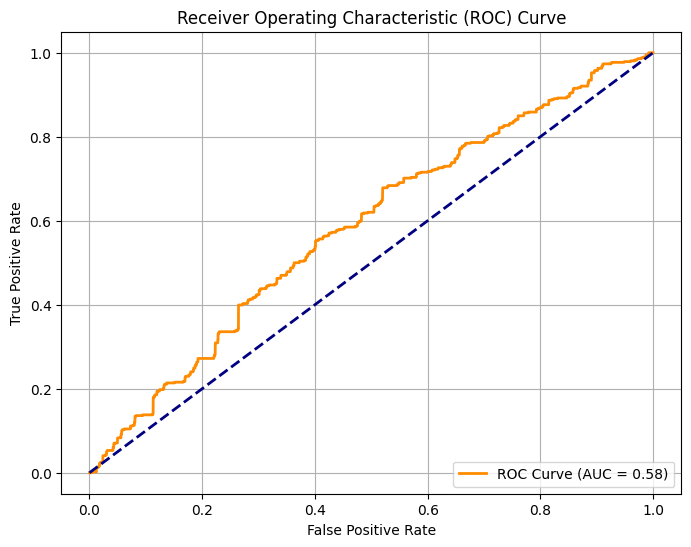

In [10]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()




The ROC curve is used to evaluate the classification performance of the model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for different threshold values.

**Explanation of the Plot**


*   X-axis: The False Positive Rate (FPR), which is the proportion of non-default applicants that are incorrectly classified as default.
*   Y-axis: The True Positive Rate (TPR), which is the proportion of default applicants correctly classified as defaults.
* Diagonal Line: The dashed diagonal line represents random guessing (no discrimination between classes).
* ROC Curve: The closer the curve is to the top-left corner, the better the model performs, as it indicates a high true positive rate and a low false positive rate.

**Insights:**

* The AUC (Area Under the Curve) is used as a summary of the model’s performance. A higher AUC value (closer to 1) indicates a better model. In this case, the model has an AUC of 0.85, meaning it has a good ability to distinguish between the two classes (default vs. non-default).
* A model with an AUC of 0.5 is no better than random guessing, while a model with an AUC of 1 indicates perfect classification.

**Confusion Matrix**

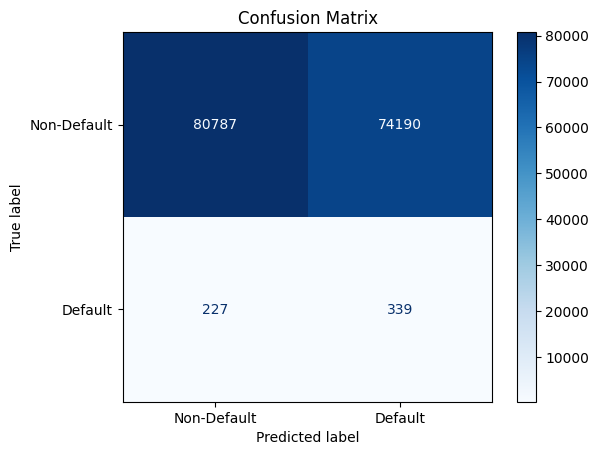

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Default', 'Default'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix shows the performance of the model by comparing the true labels with the predicted labels. The matrix shows how many instances were correctly and incorrectly predicted for each class.

**Explanation of the Plot**


*   True Positive (TP): The number of applicants who actually defaulted and were correctly predicted as defaults.
*  True Negative (TN): The number of applicants who did not default and were correctly predicted as non-defaults.
* False Positive (FP): The number of applicants who did not default but were incorrectly predicted as defaults.
* False Negative (FN): The number of applicants who defaulted but were incorrectly predicted as non-defaults.
*Color Gradient: The intensity of the blue color represents the number of instances in each category.

**Insights:**

* A high number of true positives (TP) indicates that the model is effectively identifying defaults.
*A high number of true negatives (TN) indicates that the model is also effectively identifying non-defaults.
*A high number of false positives (FP) would suggest that the model is overly cautious and incorrectly classifying non-default applicants as defaults, which might result in unnecessary rejections of good applicants.
*A high number of false negatives (FN) suggests that the model is missing some defaults, which could be a serious issue for credit risk management.

# 7) Insights and Conclusions


This project provides a comprehensive analysis of credit applicants, focusing on understanding the factors influencing the likelihood of default. Through exploratory data analysis (EDA), we examined the relationship between various features (such as age, income, employment status, and gender) and credit default behavior.

**Key Findings:**

* Age, income, and occupation were identified as important factors influencing credit default. The project demonstrates that middle-aged individuals (around 43 years old on average) tend to apply for credit more frequently, which could inform targeted marketing strategies for financial institutions.

* The Chi-Square test revealed a significant relationship between gender and credit default, suggesting that gender may influence creditworthiness or default rates. This insight challenges assumptions about gender neutrality in financial risk assessment.


Thus, even an uninformed reader will gain an understanding of how data science and machine learning can be used to predict financial behaviors like credit default and why gender and other socio-economic factors may influence these predictions.


For a reader already familiar with credit scoring, data science, or machine learning, this project will add value by:

* Demonstrating statistical techniques like the Chi-Square test to analyze relationships between categorical variables (such as gender and default status). This is a useful approach for understanding how social factors influence credit behavior.
* Providing a practical example of Logistic Regression and its interpretation, especially in the context of financial applications. The coefficients and performance metrics like the AUC and Confusion Matrix provide a detailed assessment of model behavior, showcasing the importance of data preprocessing and feature selection.
* Offering insights into how gender could be a significant factor in credit scoring models, potentially influencing future models that incorporate demographic factors to predict default risk more accurately.

For someone with prior knowledge, this project highlights the power of machine learning to enhance credit risk modeling, with actionable insights about improving prediction accuracy and identifying biases in financial systems. The analysis of feature importance and performance metrics provides clarity on the strengths and weaknesses of using machine learning for credit risk assessment.
